In [18]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import pandas as pd
import random
import string
import numpy as np

import sys, os

import torch.utils.data as data

os.environ["CUDA_VISIBLE_DEVICES"] = '0'


all_characters = string.printable
number_of_characters = len(all_characters)

artists = [
'ABBA',
'Ace Of Base',
'Aerosmith',
'Avril Lavigne',
'Backstreet Boys',
'Bob Marley',
'Bon Jovi',
'Britney Spears',
'Bruno Mars',
'Coldplay',
'Def Leppard',
'Depeche Mode',
'Drake',
'Ed Sheeran',
'Elton John',
'Elvis Presley',
'Eminem',
'Enrique Iglesias',
'Evanescence',
'Fall Out Boy',
'Foo Fighters',
'Green Day',
 'HIM',
 'Imagine Dragons',
 'Incubus',
 'Jimi Hendrix',
 'Justin Bieber',
 'Justin Timberlake',
'Kanye West',
 'Katy Perry',
 'The Killers',
 'Kiss',
 'Lady Gaga',
 'Lana Del Rey',
 'Linkin Park',
 'Madonna',
 'Marilyn Manson',
 'Maroon 5',
 'Metallica',
 'Michael Bolton',
 'Michael Jackson',
 'Miley Cyrus',
 'Nickelback',
 'Nightwish',
 'Nirvana',
 'Oasis',
 'Offspring',
 'One Direction',
 'Ozzy Osbourne',
 'P!nk',
 'Queen',
 'Radiohead',
 'Red Hot Chili Peppers',
 'Rihanna',
 'Robbie Williams',
 'Rolling Stones',
 'Roxette',
 'Scorpions',
 'Snoop Dogg',
 'Sting',
 'The Script',
 'U2',
 'Weezer',
 'Yellowcard',
 'ZZ Top']


def character_to_label(character):
    """Returns a one-hot-encoded tensor given a character.
    
    Uses string.printable as a dictionary.
        
    Parameters
    ----------
    character : str
        A character
        
    Returns
    -------
    one_hot_tensor : Tensor of shape (1, number_of_characters)
        One-hot-encoded tensor
    """
    
    character_label = all_characters.find(character)
        
    return character_label


def string_to_labels(character_string):
    
    return map(lambda character: character_to_label(character), character_string)


def pad_sequence(seq, max_length, pad_label=100):
    
    seq += [pad_label for i in range(max_length - len(seq))]
    
    return seq


class LyricsGenerationDataset(data.Dataset):
    
    def __init__(self, csv_file_path, minimum_song_count=None, artists=None):
        
        
        self.lyrics_dataframe = pd.read_csv(csv_file_path, engine='python')
        
        if artists:
            
            self.lyrics_dataframe = self.lyrics_dataframe[self.lyrics_dataframe.artist.isin(artists)]
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        if minimum_song_count:
        
            # Getting artists that have 70+ songs
            self.lyrics_dataframe = self.lyrics_dataframe.groupby('artist').filter(lambda x: len(x) > minimum_song_count)
            # Reindex .loc after we fetched random songs
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        # Get the length of the biggest lyric text
        # We will need that for padding
        self.max_text_len = self.lyrics_dataframe.text.str.len().max()
        
        whole_dataset_len = len(self.lyrics_dataframe)
        
        self.indexes = range(whole_dataset_len)
        
        
        # Let's get unique artists and form a list
        self.artists_list = list(self.lyrics_dataframe.artist.unique())
        
        # We will need the overall number of artists for 
        self.number_of_artists = len(self.artists_list)
    
    
    def __len__(self):
        
        return len(self.indexes)
    
    
    def __getitem__(self, index):
        
        index = self.indexes[index]
        
        sequence_raw_string = self.lyrics_dataframe.loc[index].text
        
        sequence_string_labels = string_to_labels(sequence_raw_string)
        
        sequence_length = len(sequence_string_labels) - 1
        
        # Shifted by one char
        input_string_labels = sequence_string_labels[:-1]
        output_string_labels = sequence_string_labels[1:]
                
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_string_labels_padded = pad_sequence(input_string_labels, max_length=self.max_text_len)
        
        output_string_labels_padded = pad_sequence(output_string_labels, max_length=self.max_text_len, pad_label=-100)
        
        ## Adding the artist label
        sequence_raw_artist_name_string = self.lyrics_dataframe.loc[index].artist

        sequence_artist_label = self.artists_list.index(sequence_raw_artist_name_string)
        
        return (torch.LongTensor(input_string_labels_padded),
                torch.LongTensor(output_string_labels_padded),
                torch.LongTensor([sequence_artist_label]),
                torch.LongTensor([sequence_length]) )

    
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, artists, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_artists_batch = artists.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_artists_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[3]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_artists_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    artists_batch_sorted = torch.cat(splitted_artists_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    
    # We should probably repeat this over the whole input sequence
    artists_batch_sorted = artists_batch_sorted.expand_as(input_sequence_batch_sorted)

    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    artists_batch_sorted_transposed = artists_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, artists_batch_sorted_transposed, lengths_batch_sorted_list


class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, num_conditions, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        self.num_conditions = num_conditions
        
        # Converts labels into one-hot encoding and runs a linear
        # layer on each of the converted one-hot encoded elements
        
        # input_size -- size of the dictionary + 1 (accounts for padding constant)
        self.characters_encoder = nn.Embedding(input_size, hidden_size)
        
        self.conditions_encoder = nn.Embedding(num_conditions, hidden_size)
        
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_conditions, input_sequences_lengths, hidden=None):
        
        batch_size = input_sequences.shape[1]

        characters_encoded = self.characters_encoder(input_sequences)
        conditions_endoded = self.conditions_encoder(input_sequences_conditions)
        
        encodings_combined = torch.cat((characters_encoded, conditions_endoded), dim=2)

        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(encodings_combined, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
        
        logits = logits.transpose(0, 1).contiguous()
        
        logits_flatten = logits.view(-1, self.num_classes)
        
        return logits_flatten, hidden


trainset = LyricsGenerationDataset(csv_file_path='songdata.csv', artists=artists)

trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                              shuffle=True, num_workers=4, drop_last=True)


In [19]:
rnn = RNN(input_size=len(all_characters) + 1,
          hidden_size=512,
          num_classes=len(all_characters),
          num_conditions=trainset.number_of_artists)

rnn.cuda()

learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()

def sample_from_rnn_conditionally(starting_sting="Why", sample_length=300, temperature=1, artist_label=0):
    
    sampled_string = starting_sting
    hidden = None

    first_input = torch.LongTensor( string_to_labels(starting_sting) ).cuda()
    first_input = first_input.unsqueeze(1)

    # Expand the artist label to have the same size as input sequence
    # we duplicate it in every input
    artist_label_input = torch.LongTensor([artist_label]).expand_as(first_input)

    current_sequence_input = Variable(first_input)
    current_artist_input = Variable(artist_label_input.cuda())

    output, hidden = rnn(current_sequence_input, current_artist_input, [len(sampled_string)], hidden=hidden)

    output = output[-1, :].unsqueeze(0)

    for i in xrange(sample_length):

        output_dist = nn.functional.softmax( output.view(-1).div(temperature) ).data

        predicted_label = torch.multinomial(output_dist, 1)

        sampled_string += all_characters[int(predicted_label[0])]
        current_sequence_input = Variable(predicted_label.unsqueeze(1))

        artist_label_input = torch.LongTensor([artist_label]).expand_as(current_sequence_input)
        current_artist_input = Variable(artist_label_input.cuda())

        output, hidden = rnn(current_sequence_input, current_artist_input, [1], hidden=hidden)
    
    return sampled_string

<IPython.core.display.Javascript object>


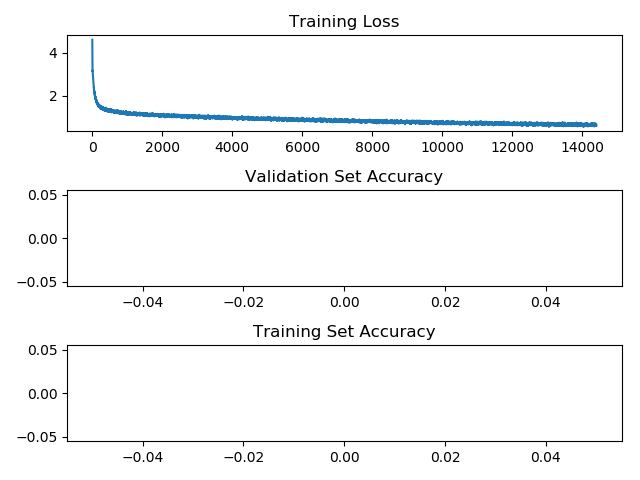

In [20]:
%matplotlib notebook

from matplotlib import pyplot as plt

# importing a list that can be binded with a figure and update
# the figure when being appended
from visualization import VizList

# Creating figure, axes and binding to lists 
f, (loss_axis, validation_axis, train_axis) = plt.subplots(3, 1)

loss_axis.plot([], [])
validation_axis.plot([], [])
train_axis.plot([], [])


loss_list = VizList()
validation_list = VizList()
train_list = VizList()

loss_list.bind_to_axis(loss_axis)
validation_list.bind_to_axis(validation_axis)
train_list.bind_to_axis(train_axis)

loss_axis.set_title('Training Loss')
validation_axis.set_title('Validation Set Accuracy')
train_axis.set_title('Training Set Accuracy')


plt.tight_layout()

In [21]:
clip = 1.0
epochs_number = 1000

for epoch_number in range(epochs_number):

    for batch in trainset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, artists_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
        
        
        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )
        artists_batch_var = Variable( artists_batch.cuda() )
        
        optimizer.zero_grad()

        logits, _ = rnn(input_sequences_batch_var, artists_batch_var, sequences_lengths)
        
        loss = criterion(logits, output_sequences_batch_var)
        loss_list.append( loss.data[0] )
        loss.backward()

        #torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

        optimizer.step()
         
    print(sample_from_rnn_conditionally(artist_label=trainset.artists_list.index("Drake")))
    torch.save(rnn.state_dict(), 'conditional_rnn.pth')
    

/home/julian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/julian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Why it wacting you frop tels and bezy so  
That's you prised  
  
Intuigh ofrest  
And o lith be've the lasle  
Came just  
So knove of youlg to Haw do Vo-yes  
Just  
I got the hone to 
  
  
Bese't resadin' you wast to show ulus bome  
So voo)  
When I light eno  
I'll gothih  
([vhen I stenly heet  
Why ladely for crarmection  
He's lie  
Hollowing up it's get in the last to you  
If it's Ving time to me  
A better be, I just way to Lamories  
Is all hell ferthratic, starke in thy cray I don't hurt this one remuidmind so heaven by t that with they sake that you only sown  
Should cheping you thing
Why, baby, yeah yeah  
  
No worf,  
Yeah) I ever seen that's a jeasure for some boke  
I got a peace bright ain't a bove you so my heart my hand am up peapendrend, spushin' to think  
And I never stitch me  
There's a hot  
So lonnow" yeah it's fine, how both she sings,  
I coull neverself that's that
Why, shot on a pictifecs for reday  
I really white's feeling honey 'xy.  
She asked muc

Why the colors of they be friends?  
Which the call to convince you young  
What happened to they get something  
Where my niggas honit is you're living ????  
Bring my breast! Like it's 3 heartbeat and white living for three same ass over  
When the flows, are out the best that you want? What's the ha
Why, you run, too much, look around  
I can be running brime as light over you, are you love, mom  
You decider, you know I, I did what I'm not doing you  
Like I'm hiding in the middle, truth, but you give a pretty  
You wrote them pleasure (it's low) but you drive me with it (like broke)  
And these 
Why can't we the ones that shit,  
The words across what we  
Its just lookin' for real,  
They look so I'm tellin'  
Nothing hurt at.  
  
Look at yourself, for The Tarvist  
Laying through the 4. I want from the country  
Ice niggas profession,  
With a handsmition are safe from above,  
Baby try to 
Why do you love? You listening do it like me  
  
I can't relace this thing shit  
That'

Why do the family open grace, help you  
Honest  
and slow how  
Try to please  
So if you think that just as full as toast  
Go and run up to the love  
(Dive your biggest supreme)  
Run and die  
  
It's everyday lies  
In one of those just disease  
It's a lot of hate  
That's the only pill  
This i
Why had the comes and things was up  
If they gave this selfish if I'm back to waste home  
It's a rhythm, I got so different, so his douge  
Look until everyone did you know?  
Mamma was in line, O Dunny, you  
Thought that somewhere in the pends of this with the style  
It's this shit, telling you th
Why did you thinkin those white room?  
If you could write a sound of man what you should be?  
Baggy of gold  
How could you be around?  
Is she only me? We breathe if  
  
We are clearless  
And if her perfume  
I start her hoes  from a pyro  
  
Beautiful  
I'm sure you're the girl I know it's a sec
Why shit it be smothering the bell  
Who could change with the top shift  
  
[Bridge:  

Why would it all figured out dry  
If I could only blow her perfume  
Funny face is pops and I'm tryna have to stay tonight  
Don't be there in this bitch or my report  
Come this shit tonight I'd feel the way to you  
This one weed that you know it?  
I know what you're things they wanna be  
They loo
Why did you tell me that life burns for? (Alright)  
Damn I should've forgotten to hold is me off a real niggas wanna here  
You condition both fives in my eyes, I'm marry it goes on to fly up no more  
But they give me out of my bedroom brick about tomorrow  
They always trust me with my lifestyline w
Why can't I tell how much more at least?  
Your princess pray  
You're mine, yeah  
You had me, you will think thing  
You hang for me, and I'll forget your foreheart  
You know that's why you're smoking lived at the tone  
And the second time or the same girl never been bothers  
Hate no more as the n
Why can't you trying to make it hard to see my mind?  
Shouldn't lie away, stop pleased 

Process Process-376:
Process Process-375:
Process Process-374:
Process Process-373:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/julian/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/julian/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/julian/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
Traceback (most recent call last):
    r = index_queue.get()
  File "/home/julian/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/julian/anaconda2/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
    self.run()
  File "/home/julian/anaconda2/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
  File "/home/julian/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in r

RuntimeError: DataLoader worker (pid 31087) exited unexpectedly with exit code 1.